In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()


/home/naif/miniconda3/envs/em2vec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/naif/miniconda3/envs/em2vec/lib/python3.8/site-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

GPU available


Processing videos: 100%|██████████| 2880/2880 [00:00<00:00, 60397.68it/s]
/home/naif/miniconda3/envs/em2vec/lib/python3.8/site-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any is

In [1]:
import pandas as pd
import numpy as np
from src.helpers import train_test_split
df = pd.read_csv("data/metadata.csv")
df = df[df['video_id'].apply(lambda x:x[:2]!='02')& (df['dataset']=='RAVDESS')].reset_index(drop=True)
# Stratified split
train_df, valid_df = train_test_split(
        df,
    )

/home/naif/miniconda3/envs/em2vec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df['emotion'].unique()

array(['fearful', 'sad', 'disgust', 'surprised', 'happy', 'angry', 'calm',
       'neutral'], dtype=object)

In [2]:
df['stratify_on']=df['dataset']+'_'+df['emotion']

In [3]:
df['stratify_on']

0         RAVDESS_fearful
1             RAVDESS_sad
2             RAVDESS_sad
3         RAVDESS_disgust
4       RAVDESS_surprised
              ...        
1435         RAVDESS_calm
1436         RAVDESS_calm
1437      RAVDESS_disgust
1438        RAVDESS_angry
1439      RAVDESS_fearful
Name: stratify_on, Length: 1440, dtype: object

In [3]:
df['emotion'].cat.categories

Index(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'],
      dtype='object')

In [4]:
df.columns

Index(['video_id', 'frame_dir', 'audio_path', 'emotion', 'target', 'dataset'], dtype='object')

In [ ]:

# imports
from src.data import create_dataloaders 
from src.train import optimize
from src.helpers import load_model, replace_insatance
import torch.nn.functional as F
import src.models as im_modesl
from torch.optim import lr_scheduler
import torch

/home/naif/miniconda3/envs/em2vec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-22 22:21:18.539832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 22:21:19.207056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Get unique classes and their counts
stratify_on =train_df['emotion'].to_numpy()
unique_classes, class_counts = np.unique(stratify_on, return_counts=True)

# Calculate class weights (inverse frequency)
n_samples = len(stratify_on)
class_weights = {}
for cls, count in zip(unique_classes, class_counts):
    # Weight = total_samples / (num_classes * count_per_class)
    class_weights[cls] = n_samples / (len(unique_classes) * count)**0.5

# Create sample weights array
sample_weights = [class_weights[t]/sum(class_weights.values()) for t in stratify_on]
sample_weights[:10]

[0.1184171671845911,
 0.1184171671845911,
 0.12094593283936474,
 0.11924238390842237,
 0.11780937617133798,
 0.11780937617133798,
 0.11780937617133798,
 0.11801093213764494,
 0.11924238390842237,
 0.11780937617133798]

In [ ]:
class_weights= torch.tensor([len(df)/(class_counts[i]*len(class_counts))**0.3 for i in range(len(class_counts)) ],dtype=torch.float32 ,device='cuda')
class_weights/=class_weights.sum()
class_weights

tensor([0.1228, 0.1209, 0.1210, 0.1225, 0.1217, 0.1496, 0.1212, 0.1204],
       device='cuda:0')

In [ ]:
# trainnig parameters
print_model=0
batch_size = 16  # size of the minibatch for stochastic gradient descent (or Adam)
num_epochs = 20    # number of epochs for training
num_classes = len(df['emotion'].cat.categories)      # number of classes. Do not change this
learning_rate =0.001*(0.6)**2  # Learning rate for SGD (or Adam)
weight_decay = 0.004     # regularization. Increase this to combat overfitting
momentum=0.9 
accumulation_steps=4
checkpoints_loading_order = ['best', 'last']
model_name= "AuVi2LSTMModel"
suffix='base'

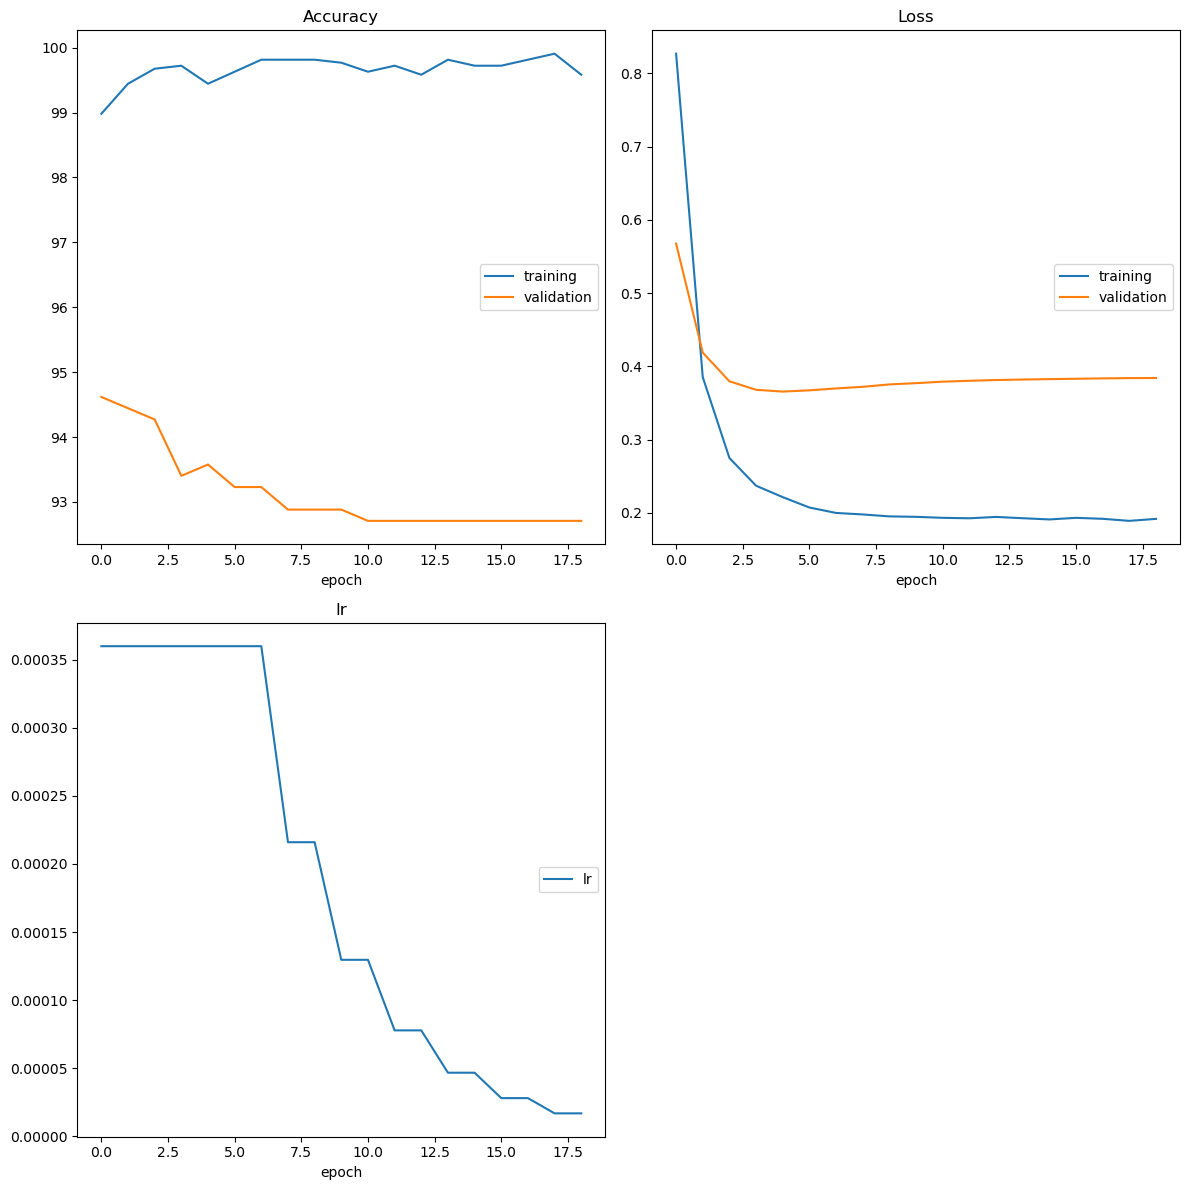

Epoch: 20 	Training Loss: 0.191873 	Validation Loss: 0.384179	Training Acc@1: 99.583 	Validation Acc@1: 92.708


Training:   0%|                                         | 0/135 [00:00<?, ?it/s]

In [ ]:

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(train_df), replacement=True, generator=None)

data_loaders = create_dataloaders(batch_size=batch_size, num_workers=8, sampler=sampler)
torch.backends.cuda.matmul.allow_tf32=True
torch.backends.cudnn.allow_tf32=True

model = getattr(im_modesl, model_name)(num_classes=num_classes)
# # initialize
# def init_weights(m):
#     if isinstance(m, torch.nn.Conv2d):
#         torch.nn.init.orthogonal_(m.weight)

# model.apply(init_weights)
# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cel
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay,)#momentum=momentum


#milestones=[5,9,12, *range(12,num_epochs,2)]
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=1,threshold=1e-3,verbose=True)
#scheduler = lr_scheduler.ExponentialLR(optimizer,gamma=0.7)

def step(loss ,epoch=None):
    scheduler.step(loss)

def loss(output,target):
    #target=F.one_hot(target, num_classes).float()
    return F.cross_entropy(output, target,label_smoothing=0.03,weight=class_weights)




s_epoch=load_model(model_name+suffix,model, checkpoints_loading_order)
if print_model:
    print(f"model {model_name} has :{sum(p.numel() for p in model.parameters())/1e6} M parameters ")
    print(f"Effictive W>0.01 precentage: ")
    print('\n'.join('layer {} has : {}'.format(n,torch.sum(torch.abs(p)>0.01)/p.numel()) for n, p in model.named_parameters()))
#replace_insatance(model,torch.nn.LeakyReLU, models.Swish())
#print(model)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    s_epoch=s_epoch,
    n_epochs=num_epochs,
    model_name=model_name+suffix,
    step=step,
    accumulation_steps=accumulation_steps,
    run_logs=True,
    interactive_tracking=True
    
)

In [ ]:
from src.train import valid_one_epoch
model = getattr(im_modesl, model_name)(num_classes=num_classes).cuda()

loss =lambda output,target: F.cross_entropy(output, target,label_smoothing=0.03, weight=class_weights)

load_model(model_name+suffix,model, checkpoints_loading_order)
valid_one_epoch(data_loaders['valid'], model, loss)

2024-11-21 22:46:06,448 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


ckpt: /home/naif/.cache/modelscope/hub/iic/emotion2vec_plus_base/model.pt
init param, map: modality_encoders.AUDIO.extra_tokens from d2v_model.modality_encoders.AUDIO.extra_tokens in ckpt
init param, map: modality_encoders.AUDIO.alibi_scale from d2v_model.modality_encoders.AUDIO.alibi_scale in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.1.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.1.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_e

Validating: 100%|███████████████████████████████| 36/36 [00:30<00:00,  1.19it/s]


(0.410528038110998, [94.09722222222223])

In [ ]:
from src.train import valid_one_epoch
import pandas as pd
import numpy as np
import torch
from src.train import to_device
from src.helpers import seed, load_model, train_test_split
from src.data import create_dataloaders
import torch.nn.functional as F
from typing import Dict, Literal


class AuViLSTMModel(torch.nn.Module):
    def __init__(
        self,
        num_classes: int = 5,
        mode: Literal["audio", "visual", "both"] = "visual",
        hidden_sizes: Dict = {"audio":384, "visual":384 },
        rnn_num_layers: int = 2,
        backbone_feat_size: int = 768
    ):
        """
        Simplified AuViLSTMModel for emotion recognition.
        
        Args:
            num_classes: Number of emotion classes
            mode: Training mode ("audio", "visual", or "both")
            rnn_hidden_size: Hidden size for LSTM layers
            rnn_num_layers: Number of LSTM layers
            backbone_feat_size: Feature size from backbone models
        """
        super().__init__()
        self.mode = mode
        
        # Visual components
        if mode in ["visual", "both"]:
            
            from transformers import AutoModelForImageClassification 

            self.v_backbone = AutoModelForImageClassification.from_pretrained(
                "dima806/facial_emotions_image_detection"
            )
            self.v_backbone.classifier = torch.nn.Identity()  # Remove classifier
            self.v_rnn = torch.nn.GRU(
                input_size=backbone_feat_size,
                hidden_size=hidden_sizes['visual'],
                num_layers=rnn_num_layers,
                batch_first=True
            )
            
            # Freeze backbone
            for param in self.v_backbone.parameters():
                param.requires_grad = False
        
        # Audio components
        if mode in ["audio", "both"]:
            from funasr import AutoModel
            audio_model = AutoModel(model="iic/emotion2vec_plus_base")
            self.a_backbone = audio_model.model
            self.a_rnn = torch.load("audio/GRU.pt")
            
            # Freeze backbone
            for param in self.a_backbone.parameters():
                param.requires_grad = False
        
        # Final classifier
        input_size = hidden_sizes[mode] if mode != "both" else hidden_sizes["visual"]+hidden_sizes["audio"]
        self.classifier = torch.nn.Linear(input_size, num_classes)
    
    def forward(self, batch: Dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Forward pass through the model.
        
        Args:
            batch: Dictionary containing 'frames' and/or 'audio' depending on mode
            
        Returns:
            torch.Tensor: Classification logits
        """
        features = []
        
        # Process visual input
        if self.mode in ["visual", "both"]:
            frames = batch['frames']
            batch_size = frames.shape[0]
            seq_len = frames.shape[1]
            
            # Reshape for backbone
            frames = frames.view(-1, *frames.shape[-3:])
            
            # Extract features
            with torch.inference_mode():
                visual_feats = self.v_backbone(frames).logits
            
            # Reshape back to sequence
            visual_feats = visual_feats.view(batch_size, seq_len, -1)
            
            # Process through GRU
            _, h_n = self.v_rnn(visual_feats)
            features.append(h_n[-1])  # Take last layer's hidden state
            # features.append(visual_feats.mean(dim=1))
        
        # Process audio input
        if self.mode in ["audio", "both"]:
            audio = batch['audio'].squeeze(1)  # Remove channel dimension
            
            # Normalize audio
            audio = torch.nn.functional.layer_norm(audio, [audio.shape[-1]])
            
            # Extract features
            with torch.inference_mode():
                audio_feats = self.a_backbone.extract_features(audio)['x']
            
            # Process through GRU
            _, h_n = self.a_rnn(audio_feats)
            features.append(h_n[-1])  # Take last layer's hidden state
        
        # Combine features and classify
        combined_features = torch.cat(features, dim=-1) if len(features) > 1 else features[0]
        return self.classifier(combined_features)

2024-12-01 07:07:20.798240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 07:07:21.400397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
def evaluate_model_with_predictions(model, dataloader):
    """
    Evaluate model and return accuracies along with predictions and ground truths.
    
    Returns:
        tuple: (unweighted_acc, weighted_acc, predictions, ground_truths)
    """
    model.eval()
    total_unweighted = 0
    n_batches = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = to_device(inputs, 'cuda')
            targets = to_device(targets, 'cuda')
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct = (preds == targets).float()
            
            # Unweighted accuracy
            unweighted_acc = correct.mean().item()
            
            
            total_unweighted += unweighted_acc

            n_batches += 1
    
    return (
        total_unweighted / n_batches, 
        np.array(all_preds),
        np.array(all_targets)
    )

In [7]:
checkpoints_loading_order = ['best', 'last']
results =[]
df = pd.read_csv("data/metadata.csv")
df = df[(df['dataset']=='UJ_ACTORS')].reset_index(drop=True)
df['stratify_on']=df['dataset']+'_'+df['emotion']

model = AuViLSTMModel(num_classes=8, mode= 'visual').cuda()

loss_fn =lambda output,target: F.cross_entropy(output, target,label_smoothing=0.03)
for fold in range(5):
    current_seed = seed + fold
    torch.manual_seed(current_seed)
    np.random.seed(current_seed)
    
    # Split data
    train_fold, valid_fold = train_test_split(
        df, test_size=0.2,
        stratify=df['stratify_on'],
        random_state=current_seed
    )

    model_name = f"visual_fold{fold}"
    load_model(model_name,model,loading_order=checkpoints_loading_order, checkpoints_dir="experiments/20241130_235623_sequential_training/model_checkpoints")

    valid_loader = create_dataloaders(df, batch_size=1 , valid_df=valid_fold)['valid'] # we will use only valid_df
    result =evaluate_model_with_predictions(model, valid_loader)
    results.append([fold,"best", *result])

    load_model(model_name,model,loading_order=checkpoints_loading_order[::-1], checkpoints_dir="experiments/20241130_235623_sequential_training/model_checkpoints")
    valid_loader = create_dataloaders(df, batch_size=1 , valid_df=valid_fold)['valid'] # we will use only valid_df
    result =evaluate_model_with_predictions(model, valid_loader)
    results.append([fold,"best", *result])

/home/naif/projects/videoEmotionRecognition/src/helpers.py:521: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{checkpoints_dir}/{loading_order[0]}_

Previously trained model weights state_dict loaded...
Previously trained for 28 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 30 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 30 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 30 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 29 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 30 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 27 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 30 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 28 number of epochs...
Previously trained model weights state_dict loaded...
Previously trained for 30 number of epochs...


In [8]:
results

[[0,
  'best',
  0.25,
  array([1, 6, 1, 6, 6, 1, 1, 2, 1, 1, 3, 1, 1, 4, 4, 1, 1, 1, 6, 1, 1, 0,
         4, 1]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
         7, 7])],
 [0,
  'best',
  0.25,
  array([1, 6, 1, 6, 6, 1, 1, 2, 1, 1, 3, 1, 1, 4, 4, 1, 1, 1, 6, 1, 1, 0,
         4, 1]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
         7, 7])],
 [1,
  'best',
  0.25,
  array([1, 4, 0, 1, 6, 1, 1, 2, 1, 0, 0, 4, 1, 1, 4, 1, 1, 1, 6, 1, 1, 0,
         1, 0]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
         7, 7])],
 [1,
  'best',
  0.25,
  array([1, 4, 0, 1, 6, 1, 1, 2, 1, 0, 0, 4, 1, 1, 4, 1, 1, 1, 6, 1, 1, 0,
         1, 0]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
         7, 7])],
 [2,
  'best',
  0.08333333333333333,
  array([1, 4, 1, 0, 0, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 6, 1, 3, 1, 1, 4,
         1, 4]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3,

In [ ]:
model = AuViLSTMModel(num_classes=len(df['emotion'].cat.categories), mode= 'both')

2024-12-01 04:16:06,177 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


ckpt: /home/naif/.cache/modelscope/hub/iic/emotion2vec_plus_base/model.pt
init param, map: modality_encoders.AUDIO.extra_tokens from d2v_model.modality_encoders.AUDIO.extra_tokens in ckpt
init param, map: modality_encoders.AUDIO.alibi_scale from d2v_model.modality_encoders.AUDIO.alibi_scale in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.1.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.1.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_e

/tmp/ipykernel_1335197/3016258471.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.a_rnn = torch.load("GRU.pt")


In [20]:
checkpoints_loading_order = ['best', 'last']
results =[]
df = pd.read_csv("data/metadata.csv")
df = df[(df['dataset']=='UJ_ACTORS')].reset_index(drop=True)
df['stratify_on']=df['dataset']+'_'+df['emotion']

model = AuViLSTMModel(num_classes=8, mode= 'audio').cuda()

loss_fn =lambda output,target: F.cross_entropy(output, target,label_smoothing=0.03)
for fold in range(5):
    current_seed = seed + fold
    torch.manual_seed(current_seed)
    np.random.seed(current_seed)
    
    # Split data
    train_fold, valid_fold = train_test_split(
        df, test_size=0.2,
        stratify=df['stratify_on'],
        random_state=current_seed
    )

    model_name = f"audio_fold{fold}"
    load_model(model_name,model,loading_order=checkpoints_loading_order, checkpoints_dir="experiments/20241130_235623_sequential_training/model_checkpoints")

    valid_loader = create_dataloaders(df, batch_size=1 , valid_df=valid_fold)['valid'] # we will use only valid_df
    loss, topk_auc =valid_one_epoch(valid_loader, model, loss_fn)
    results.append([fold,"best", loss,topk_auc[0]])

    load_model(model_name,model,loading_order=checkpoints_loading_order[::-1], checkpoints_dir="experiments/20241130_235623_sequential_training/model_checkpoints")
    valid_loader = create_dataloaders(df, batch_size=1 , valid_df=valid_fold)['valid'] # we will use only valid_df
    loss, topk_auc =valid_one_epoch(valid_loader, model, loss_fn)
    results.append([fold,"last", loss,topk_auc[0]])

2024-12-01 06:40:16,216 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


ckpt: /home/naif/.cache/modelscope/hub/iic/emotion2vec_plus_base/model.pt


/home/naif/miniconda3/envs/em2vec/lib/python3.8/site-packages/funasr/train_utils/load_pretrained_model.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  src_state = torch

init param, map: modality_encoders.AUDIO.extra_tokens from d2v_model.modality_encoders.AUDIO.extra_tokens in ckpt
init param, map: modality_encoders.AUDIO.alibi_scale from d2v_model.modality_encoders.AUDIO.alibi_scale in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.1.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.1.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.1.2.1.weight from d2v_model.modality_encoders.AUDIO.loc

/tmp/ipykernel_2501274/2523369789.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.a_rnn = torch.load("GRU.pt")
/home/naif/projects/videoEmotionRecognition/src/help

Previously trained model weights state_dict loaded...
Previously trained for 12 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.97it/s]


Previously trained model weights state_dict loaded...
Previously trained for 15 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 22.01it/s]


Previously trained model weights state_dict loaded...
Previously trained for 13 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.99it/s]


Previously trained model weights state_dict loaded...
Previously trained for 15 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 20.67it/s]


Previously trained model weights state_dict loaded...
Previously trained for 14 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.16it/s]


Previously trained model weights state_dict loaded...
Previously trained for 15 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.81it/s]


Previously trained model weights state_dict loaded...
Previously trained for 14 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.14it/s]


Previously trained model weights state_dict loaded...
Previously trained for 15 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.48it/s]


Previously trained model weights state_dict loaded...
Previously trained for 13 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 21.92it/s]


Previously trained model weights state_dict loaded...
Previously trained for 15 number of epochs...


Validating: 100%|███████████████████████████████| 24/24 [00:01<00:00, 20.93it/s]


In [21]:
results

[[0, 'best', 2.736377915988366, 33.333333333333336],
 [0, 'last', 2.7501519446571674, 33.333333333333336],
 [1, 'best', 2.8021961115300664, 33.333333333333336],
 [1, 'last', 2.8494909064223366, 37.5],
 [2, 'best', 2.4456141820798316, 33.333333333333336],
 [2, 'last', 2.574896389618516, 20.833333333333332],
 [3, 'best', 1.9726727865636349, 37.5],
 [3, 'last', 1.9777622874826193, 37.5],
 [4, 'best', 2.169513486325741, 37.5],
 [4, 'last', 2.184055851151546, 41.666666666666664]]